<a href="https://colab.research.google.com/github/vincm1/UK_accidents/blob/main/Final_assignment_Big_Data_for_Decision_Making_(2021_22_BNK432_NO02_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Final assignment - Big Data for Decision Making (2021-22 BNK432_NO02_A)

In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("UK Road Accidents 2018.csv")
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


In [ ]:
df.tail()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
8535,2018-12-31 19:00:00,13,Monday,Fine,False,Dry,Darkness - lights lit,Urban
8536,2018-12-31 20:00:00,12,Monday,Fine,False,Dry,Darkness - lights lit,Urban
8537,2018-12-31 21:00:00,5,Monday,Fine,False,Dry,Darkness - lights lit,Urban
8538,2018-12-31 22:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
8539,2018-12-31 23:00:00,9,Monday,Fine,False,Dry,Darkness - lights lit,Urban


## 1) **Business** **objective**

The above seen data set is published by the UK Department for Transport and is published sinced 1978. For this report, a snippet of the data is taken and handles all road accidents that happened in 2018 on an hourly level. The data contains information about the hour as well as the count of how many accidents happened on UK's streets. Furthermore, it shows which day of the week it has been, the condition of precipitation within that time as well as whether there was high wind. Moreover, the dataset contains information about the road surface conditions, light conditions and in what kind of area the accidents in that hour happened.

The goal of this report is to forecast the number of hourly accidents occuring on UK streets for Britannia Rescue in order to help its rescourcing planning by an appropriate model.

To predict the numbers the following report structure will be included. First, the data will explored and preprocessed. Secondly, the features are selected and a baseline model will be drawn. Thirdly, models will be trained, hyperparameters tuned and thereby evaluated, which model shows the best performance for predicting road accidents for the client. To sum up, the results will be discussed and further steps will be introduced.

### **2) EDA**

In [ ]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area'],
      dtype='object')

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [ ]:
df.dtypes

datetime                   datetime64[ns]
Count                               int64
Day_of_Week                        object
Precipitation                      object
High_Winds                           bool
Road_Surface_Conditions            object
Light_Conditions                   object
Urban_or_Rural_Area                object
dtype: object

In [ ]:
df["day"] = df["datetime"].dt.date
df["day"] = pd.to_datetime(df["day"])

In [ ]:
df["hour"] = df["datetime"].dt.hour

In [ ]:
df = df[['datetime', 'day', 'hour', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]

In [ ]:
cat_names = ['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Day_of_Week 7
Precipitation 7
High_Winds 2
Road_Surface_Conditions 6
Light_Conditions 5
Urban_or_Rural_Area 2


In [ ]:
for i in cat_names:
  print(i,df[i].unique())

Day_of_Week ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Precipitation ['Fine' 'Other' 'Raining' 'Fog or mist' 'Unknown' 'Snowing'
 'Data missing or out of range']
High_Winds [False  True]
Road_Surface_Conditions ['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep'
 'Data missing or out of range']
Light_Conditions ['Darkness - lights lit' 'Daylight' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - lights unlit']
Urban_or_Rural_Area ['Urban' 'Rural']


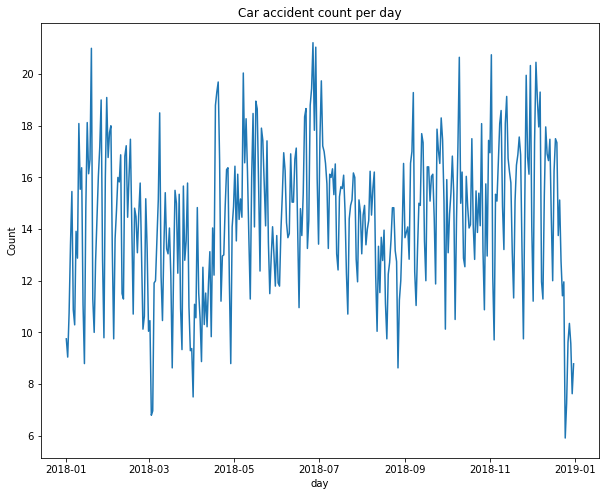

In [ ]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df, x=df.day, y=df["Count"], ci=None)
plt.title("Car accident count per day")
plt.show()

In [ ]:
train_set, test_set = train_test_split(df,test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} tain and {test_set.shape[0]} test instances")

6832 tain and 1708 test instances


In [ ]:
train_set.head()

,datetime,day,hour,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,2018-01-01,0,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,2018-01-01,1,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,2018-01-01,2,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,2018-01-01,3,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,2018-01-01,4,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6832 entries, 0 to 6831
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 6832 non-null   datetime64[ns]
 1   day                      6832 non-null   datetime64[ns]
 2   hour                     6832 non-null   int64         
 3   Count                    6832 non-null   int64         
 4   Day_of_Week              6832 non-null   object        
 5   Precipitation            6832 non-null   object        
 6   High_Winds               6832 non-null   bool          
 7   Road_Surface_Conditions  6832 non-null   object        
 8   Light_Conditions         6832 non-null   object        
 9   Urban_or_Rural_Area      6832 non-null   object        
dtypes: bool(1), datetime64[ns](2), int64(2), object(5)
memory usage: 540.4+ KB


In [ ]:
print(f"From ",df["day"].min(), "to ", df["day"].max(),": " ,df.Count.sum()," accidents occured.")

From  2018-01-01 00:00:00 to  2018-12-31 00:00:00 :  122622  accidents occured.


In [ ]:
for i in df[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = df[i].value_counts()
    print("Column name is: ",i,"and it value is:",x)

Column name is:  Day_of_Week and it value is: Sunday       1244
Saturday     1243
Monday       1234
Friday       1217
Wednesday    1206
Thursday     1204
Tuesday      1192
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and it value is: Fine                            7492
Raining                          808
Snowing                          117
Other                             51
Unknown                           48
Fog or mist                       23
Data missing or out of range       1
Name: Precipitation, dtype: int64
Column name is:  High_Winds and it value is: False    8471
True       69
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and it value is: Dry                             6303
Wet or damp                     2053
Snow                             115
Frost or ice                      53
Data missing or out of range      11
Flood over 3cm. deep               5
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Cond

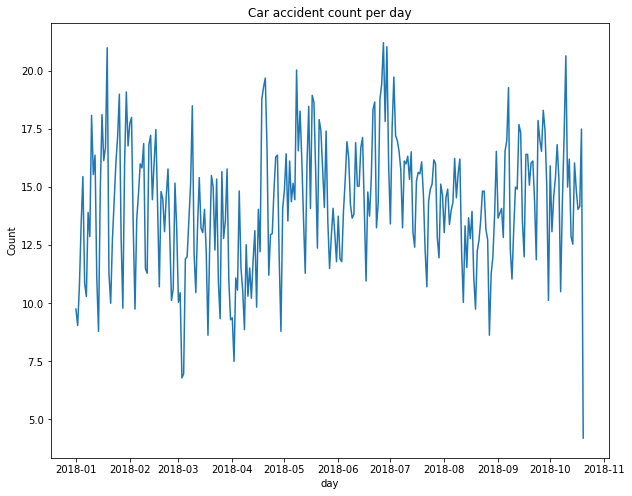

In [ ]:
plt.figure(figsize=(10,8))
sns.lineplot(data=train_set, x=train_set.day, y=train_set["Count"], ci=None)
plt.title("Car accident count per day")
plt.show()

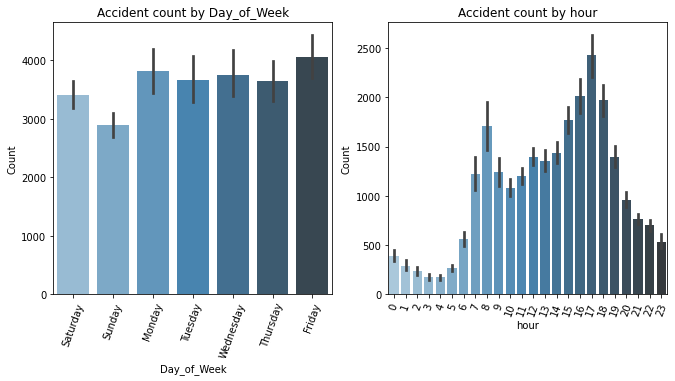

In [ ]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[["Day_of_Week","hour"]]:
    plt.subplot(1, 3, c)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

Concerning the date and time of the data one can recognize that accidents are evenly distributed between the weekdays and only *sligthly* peak on Fridays and have a *slight* bottom on Sundays. 
Regarding the hours there is a more clear distribution towards the rush hour hours from 16:00 to 18:00 as well as in the mornings between 7:00 and 9:00. 

In [ ]:
test_set.columns

Index(['datetime', 'day', 'hour', 'Count', 'Day_of_Week', 'Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area'],
      dtype='object')

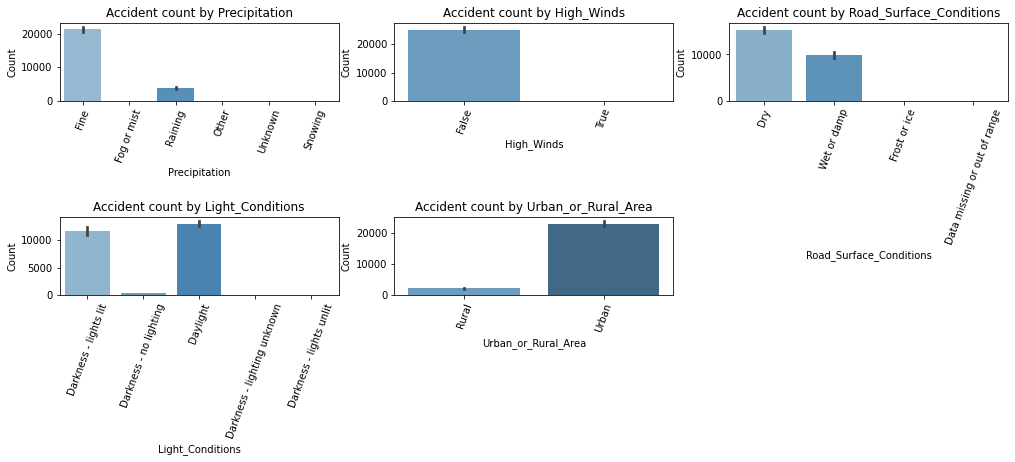

In [ ]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[['Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area']]:
    plt.subplot(2, 3, c)
    plt.subplots_adjust(hspace=1.5)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

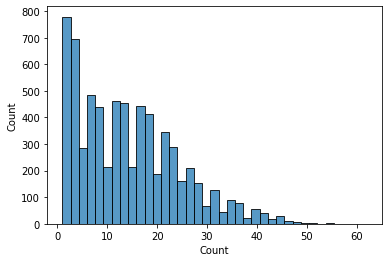

In [ ]:
sns.histplot(data=train_set, x="Count")

### 3) **Data Preprocessing**

In [ ]:
train_set.isna().sum()

datetime                   0
day                        0
hour                       0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
dtype: int64

### ARIMA Model

In [ ]:
df_time_series = df[["datetime","Count"]]
df_time_series.plot()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1bb17da5f0> (for post_execute):


ValueError: ignored

ValueError: ignored